In [1]:
import numpy as np
from sklearn.model_selection import train_test_split 
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
from sklearn import metrics
from IPython.display import clear_output
from qiskit.utils import algorithm_globals
from qiskit import QuantumCircuit
#from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B,GradientDescent, ADAM
from qiskit.algorithms.optimizers.optimizer import Optimizer, OptimizerSupportLevel, OptimizerResult, Minimizer
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import OptimizerResult
from qiskit_machine_learning.utils.loss_functions import (
    Loss,
    L1Loss,
    L2Loss,
    CrossEntropyLoss,
)
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor
from qiskit.circuit import ParameterVector
from sklearn.preprocessing import MinMaxScaler
import math
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS,SGD,Adam
from qiskit_machine_learning.connectors import TorchConnector
from torch.utils.data import TensorDataset,DataLoader

/tmp/ipykernel_108043/2594626489.py:11: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers.optimizer import Optimizer, OptimizerSupportLevel, OptimizerResult, Minimizer


In [2]:
def norminv(x):
    return ((1.0/math.sqrt(2.0*math.pi)) * math.exp(-x*x*0.5))

def d1(S0, K, r, T, sigma, q):
    deno = (sigma * math.sqrt(T))
    if (deno==0):
        return 0
    logReturns = math.log(S0/float(K)) if ((S0/float(K)) > 0.0) else 0.0
    return (float(logReturns) + (float(r) - float(q) + float(sigma)*float(sigma)*0.5)*float(T)) / float(deno)
    
def d2(S0, K, r, T, sigma, q):
        return d1(S0, K, r, T, sigma, q)-sigma*math.sqrt(T)
        
def bsformula(callput, S0, K, r, T, sigma, q=0):
    N = stats.norm.cdf
                
    def optionValueOfCall(S0, K, r, T, sigma, q):       
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return S0*math.exp(-q*T)*N(_d1)- K*math.exp(-r*T)*N(_d2)
      
    def optionValueOfPut(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return float(K)*math.exp(-float(r)*float(T))*N(-_d2) - float(S0)*math.exp(-float(q)*float(T))*N(-_d1)
        
    def delta(callput, S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)        
        if callput.lower() == "call":            
            return N(_d1) * math.exp(-q*T)
        else:
            return (N(_d1)-1)* math.exp(-q*T)
    
    def vega(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        return S0  * math.sqrt(T) * norminv(_d1)  * math.exp(-q*T)
    
    if callput.lower()=="call":
        optionValue = optionValueOfCall(S0, K, r, T, sigma, q)
    else:
        optionValue = optionValueOfPut(S0, K, r, T, sigma, q)
        
    _delta = delta(callput, S0, K, r, T, sigma, q)
    _vega = vega(S0, K, r, T, sigma, q)
    
    return (optionValue, _delta, _vega)

def bsm_iv_generator(num_sample = 100,tao_bound=[0.01,2.0],  sigma_bound=[0.01,2.0], 
                     money_bound=[0.3,3.0], rr_bound=[0.01,0.2], callput='call', seed=42):
    
    # input parameters: when callput is not in 'call' or 'put', randomly generate the option price followed by root-finding methods to
    # compute the corresponding implied vol
    # return: X_input = [time,stock,rr, dividen, option_price]. Y_outpu  = volatility 
    np.random.seed(seed)
    tao_min,tao_max = tao_bound[0],tao_bound[1]
    
    sigma_min, sigma_max = sigma_bound[0],sigma_bound[1]
    moneyness_min,moneyness_max = money_bound[0],money_bound[1]
    rr_min,rr_max = rr_bound[0],rr_bound[1]
   
    

    num_sample = int(num_sample)
    xx = np.zeros([num_sample,4],dtype='float')
    
   
    xx[:,0] = np.random.uniform(sigma_min, sigma_max,xx.shape[0])
    xx[:,1] = np.random.uniform(tao_min,tao_max,xx.shape[0])
    xx[:,2] = np.random.uniform(moneyness_min,moneyness_max,xx.shape[0])
    xx[:,3] = np.random.uniform(rr_min,rr_max,xx.shape[0])
   
    
   
    strike=1.0 #fixed strike
    #callput = 'call' # call option
    v = np.zeros(xx.shape[0]) # option value
    k = np.ones(xx.shape[0]) # strike price, just in order to match the shape of v
    
    if callput in ['call','put']:        
        for i in range(0,xx.shape[0]):        
            sigma, T, S0, interest = xx[i,0],xx[i,1],xx[i,2],xx[i,3]
            ## use the Black-Schole function in compfin.py
            v[i] = bsformula(callput, S0, strike, interest, T, sigma)[0]              
            
  
    v= v.reshape(xx.shape[0],1)     
    xx_sample = np.concatenate((xx,v),axis=1) #sigma, time, s, r, v
    
    
    X_input   = xx_sample[:,1:]   # time,stock,rr, option_price
    Y_output  =  xx_sample[:,0] # sigma -implied volatility is the predictive variable.
  
    return X_input,Y_output
#  log-transformation of the option value
def logscale_vol(x_train_dat,y_train_dat,otm_lower=0.0000001):
   # input data: x_train_dat = [time,stock,rr, option_price], y_train_dat = sigma  
   
    xtv_train_log=x_train_dat.copy()    
    ytv_train_log =y_train_dat.copy()
    
    
    #v_lower[v_lower<0.0]=0.0 # V=max(S-E*exp(-rt),0)  
    xintrinsic_train=xtv_train_log[:,1]-1.0*np.exp(-1.0*xtv_train_log[:,2]*xtv_train_log[:,0])
    xintrinsic_train[xintrinsic_train<0.0]=0.0 ## \tilde{V} = max(S-E*exp(-rt),0)
    xtv_train_log[:,-1] = xtv_train_log[:,-1] -xintrinsic_train
    
    ## remove intrisinc values below the threshold (otm_lower \approx machine pricision)  
   
    ytv_train_log = ytv_train_log[~np.less(xtv_train_log[:,-1],otm_lower)]
    xtv_train_log = xtv_train_log[~np.less(xtv_train_log[:,-1],otm_lower),:]
    xtv_train_log[:,-1]=np.log(xtv_train_log[:,-1])

    return xtv_train_log,ytv_train_log 


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    print(obj_func_eval)
    #plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    
    
def layer(W,n_qubits):
    
    """Applies a layer of arbitrary rotations and circular entanglements to the variational circuit

    Args:
        W (np.ndarray): rotation parameters for the layer
    """
    '''
    qc = QuantumCircuit(n_qubits)
    k=0
    for i in range(n_qubits):
        qc.u(W[i*3], W[i*3 + 1], W[i*3 + 2], i)
    for i in range(n_qubits-1):
        qc.cnot(i, i+1)
    if n_qubits > 2:
        qc.cnot(n_qubits-1, 0)
        
    for i in range(n_qubits-1):
        for j in range(i+1, n_qubits):
            qc.rxx(W[3*n_qubits+k*3], i, j)
            qc.ryy(W[3*n_qubits+k*3+ 1], i, j)
            qc.rzz(W[3*n_qubits+k*3+ 2], i, j)
            k=k+1
            
    
    if n_qubits > 2:
        qc.rxx(W[3*(2*n_qubits-1)+i*3], i, i+1)
        qc.ryy(weights[3*(2*n_qubits-1)+i*3+ 1], i, i+1)
        qc.rzz(weights[3*(2*n_qubits-1)+i*3+ 2], i, i+1)
    '''

    qc = QuantumCircuit(n_qubits)
    k=0
    for i in range(n_qubits):
        qc.u(W[i*3], W[i*3 + 1], W[i*3 + 2], i)
    '''
        qc.rz(W[i*3], i)
        qc.ry(W[i*3 + 1], i)
        qc.rz(W[i*3 + 2], i)
    '''
    for i in range(n_qubits-1):
        qc.cnot(i, i+1)
    
    if n_qubits > 2:
        qc.cnot(n_qubits-1, 0)
    
    
    return qc


def global_phase_gate(qc, phase, qubit):
    qc.p(phase, qubit)
    qc.x(qubit)
    qc.p(phase, qubit)
    qc.x(qubit)

def statepreparation(x,n_qubits,l):

    qc = QuantumCircuit(n_qubits)
    
    for i in range(n_qubits):
        #qc.h(i)
        #qc.p(x[i]* np.pi/2, i)
        #qc.ry(x[i] * np.pi, i)
        qc.ry(x[i]*(l+1), i)
        #qc.rz(x[i], i)
        #global_phase_gate(qc, -np.pi/2, i)
    '''
    for i in range(n_qubits-1):
        qc.cnot(i, i+1)

        '''
    
    return qc

def min_max_normalization(arr):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = [(x - min_val) / (max_val - min_val) for x in arr]
    return normalized_arr




maturity time  range:
0.5046450412719997 0.5965632033074559
Stock price  range:
0.9534388521115218 1.0469584627764559
interest rate  range:
0.020165663513708073 0.04960660809801552
option value  range:
0.0882003772230015 0.21781486609408834
sigma range:
0.308233797718321 0.6879639408647977
(20, 4)
maturity time  range:
0.5046450412719997 0.5965632033074559
Stock price  range:
0.9534388521115218 1.0469584627764559
interest rate  range:
0.020165663513708073 0.04960660809801552
time option-value  range:
-2.7849557612427844 -1.6908555893450807
sigma range:
0.308233797718321 0.6879639408647977
(20, 4)


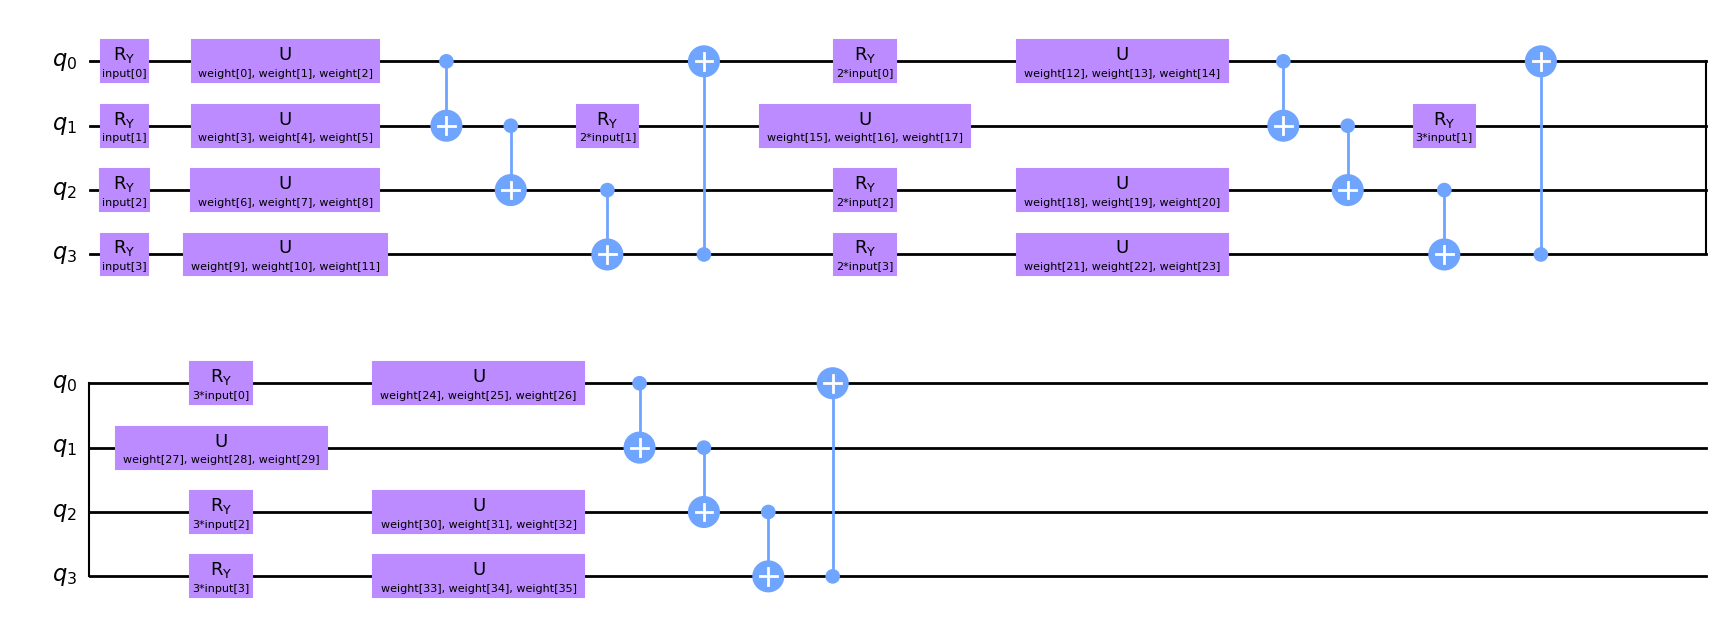

In [3]:
algorithm_globals.random_seed = 42

################################################data preparation###############################################################

Xin_input,Yin_output=bsm_iv_generator(num_sample = 20,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[0.95,1.05], rr_bound=[0.02,0.05],callput='call')

#check the data value range on each dimension
## xin = [maturity time, Stock price, interest rate, dividend, option value]

xlabel =  ['maturity time', 'Stock price', 'interest rate','option value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(Xin_input[:,i]),np.max(Xin_input[:,i]))
    
print('sigma range:')
print(np.min(Yin_output),np.max(Yin_output))
print(np.shape(Xin_input))

# generate and shuffle the data set into training and test part
xtv_train_log_all,ytv_train_log_all=logscale_vol(Xin_input,Yin_output,otm_lower=1e-4)
'''
for i in range(4):
    xtv_train_log_all[:,i]= min_max_normalization(xtv_train_log_all[:,i])
'''
#ytv_train_log_all=ytv_train_log_all/2
xtv_train_log,xtv_test_log, ytv_train_log, ytv_test_log   = train_test_split(xtv_train_log_all,ytv_train_log_all,test_size=0.2,random_state=42)

xlabel =  ['maturity time', 'Stock price', 'interest rate','time option-value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(xtv_train_log_all[:,i]),np.max(xtv_train_log_all[:,i]))
    
print('sigma range:')
print(np.min(ytv_train_log),np.max(ytv_train_log))
## how many samples after cleaning
print(np.shape(xtv_train_log_all))
##############################quantum circuit################
n_qubits=4
inputs = ParameterVector("input", 4)
weights = ParameterVector("weight", 36)
n_layers=3

# prepare the quantum circuit
qc = QuantumCircuit(n_qubits)

for l in range(n_layers):
    qc = qc.compose(statepreparation(inputs,n_qubits,l))
   #qc = qc.compose(layer(weights[3*(n_qubits+1) * int(n_qubits/2) * l: 3*(n_qubits+1) * int(n_qubits/2) * (l+1)],n_qubits))
    qc = qc.compose(layer(weights[3*(n_qubits) * l: 3*(n_qubits+1)  * (l+1)],n_qubits))
qc.draw(output="mpl")

In [4]:
from qiskit.quantum_info import SparsePauliOp
algorithm_globals.random_seed = 12
###################################################### construct QNN

regression_estimator_qnn = EstimatorQNN(
    circuit=qc ,input_params=inputs, weight_params=weights)
input_data = xtv_train_log
label=ytv_train_log

'''
trainset=MyDataset(x=input_data,y=label)
train_loader = DataLoader(trainset, batch_size=1, shuffle=True)
'''
trainset=TensorDataset(Tensor(input_data),Tensor(label).unsqueeze(1))
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
qnn_weights = algorithm_globals.random.random(regression_estimator_qnn.num_weights)
#qnn_weights = np.loadtxt("w.txt")
print(qnn_weights)

[0.25082446 0.94675294 0.18932038 0.17929141 0.34988924 0.23054125
 0.67044574 0.11507938 0.89630937 0.85813049 0.00282703 0.54146616
 0.10685127 0.25795496 0.41689604 0.45361612 0.46814659 0.9275167
 0.25877109 0.18789021 0.67051047 0.9466187  0.92281088 0.88025
 0.0643557  0.93669612 0.64924037 0.87155585 0.40809847 0.21938993
 0.79297008 0.66163447 0.77884009 0.2013447  0.13435174 0.76362509]


In [5]:
model = TorchConnector(regression_estimator_qnn, qnn_weights)

In [6]:
optimizer = Adam(model.parameters(),lr= 0.01)
f_loss = MSELoss()
start_time=time.time()
loss_list=[]
r2_list=[]
grad_list=[]
weight_list=[]

epochs = 1000
weight_list.append(qnn_weights)
for epoch in range(epochs):
    total_loss  = []
    total_r2  = []
    print(f"epoch {epoch+1}\n-------------------------------")
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = f_loss(output, target)
        R2=metrics.r2_score(target.detach().numpy(), output.detach().numpy())
        # Backward pass
        loss.backward()
        for name, param in model.named_parameters():
            if param.requires_grad:
                weights_trained_t=param.data.numpy()
                grad_t=param.grad.numpy()
                grad_list.append(grad_t)
                weight_list.append(weights_trained_t)
        # Optimize the weights
        optimizer.step()
        total_loss.append(loss.item())
        total_r2.append(R2)
        end_timet=time.time()
        print("batch_idx:",batch_idx,"loss:",loss.item(),"R2:",R2,"time:",end_timet)
    loss_list.append(sum(total_loss)/len(total_loss))
    r2_list.append(sum(total_r2)/len(total_r2))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]),"time:",end_timet)

epoch 1
-------------------------------
batch_idx: 0 loss: 0.06611038744449615 R2: -5.5562911191217355 time: 1696202602.0765264
batch_idx: 1 loss: 0.005540897604078054 R2: -1.5631261896824378 time: 1696202605.4395328
batch_idx: 2 loss: 0.08249133825302124 R2: -7.643496535175242 time: 1696202608.5660343
batch_idx: 3 loss: 0.06309623271226883 R2: -2.3049505044957797 time: 1696202611.881428
Training [0%]	Loss: 0.0543 time: 1696202611.881428
epoch 2
-------------------------------
batch_idx: 0 loss: 0.05503810569643974 R2: -2.5258573317763013 time: 1696202615.3749242
batch_idx: 1 loss: 0.03179951757192612 R2: -58.47586587860787 time: 1696202618.2662096
batch_idx: 2 loss: 0.03730177879333496 R2: -1.4017882484862914 time: 1696202621.7191837
batch_idx: 3 loss: 0.012487124651670456 R2: -0.641526207143698 time: 1696202624.668976
Training [0%]	Loss: 0.0342 time: 1696202624.668976
epoch 3
-------------------------------
batch_idx: 0 loss: 0.042061179876327515 R2: -0.6177825784408468 time: 1696202

In [7]:
for w,param in model.named_parameters():
        if param.requires_grad:
            weights_trained=param.data.numpy()
print(weights_trained)

[ 2.7851191e-01  7.7187800e-01 -8.6160679e-04 -1.8936552e-01
  5.9424388e-01  5.2889788e-01  4.0275294e-01  1.4981173e+00
  1.4374238e+00  4.3447119e-01 -2.2736095e-02  5.9956825e-01
  5.0873482e-01  5.7268429e-01  7.7805406e-01 -9.4290185e-01
  2.9629710e-01  5.5590838e-01  2.3591690e-01  4.4676220e-01
  9.9220371e-01  8.3021563e-01  7.5209868e-01  6.0273784e-01
 -2.7581906e-01  9.3669611e-01  1.3104399e-01  8.7155586e-01
  4.0809846e-01  2.1938993e-01  9.1566813e-01  6.6163445e-01
  6.9741940e-01  2.0134470e-01  1.3435173e-01  7.6362509e-01]


train_MSE: 0.00023456352468434957
train_RMSE: 0.015315466845132393
train_MAE: 0.012108006927717987
train_MAPE: 0.02613499764345179
train_R2: 0.9840049427299049


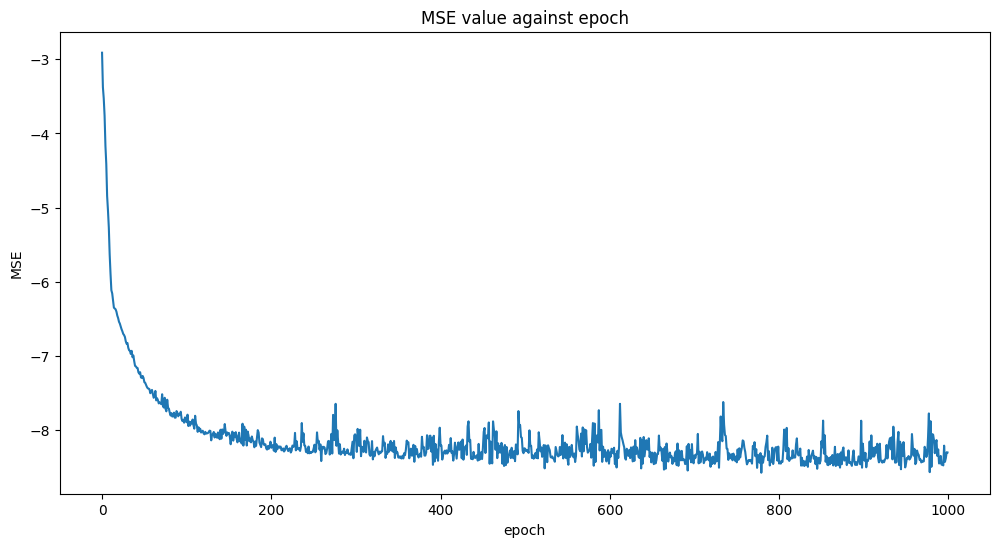

In [8]:
predict_value_train= model(Tensor(input_data)).detach().numpy()
true_value_train=np.array(label).reshape(predict_value_train.shape)
train_MSE=metrics.mean_squared_error(true_value_train,predict_value_train)


train_RMSE=train_MSE**(1/2)

train_MAE=metrics.mean_absolute_error(true_value_train,predict_value_train)
train_MAPE=metrics.mean_absolute_percentage_error(true_value_train,predict_value_train)
train_R2=metrics.r2_score(true_value_train, predict_value_train)

print("train_MSE:",train_MSE)
print("train_RMSE:",train_RMSE)
print("train_MAE:",train_MAE)
print("train_MAPE:",train_MAPE)
print("train_R2:",train_R2)

plt.rcParams["figure.figsize"] = (12, 6)

plt.title("MSE value against epoch")
plt.xlabel("epoch")

plt.ylabel("MSE")
plt.plot(range(len(loss_list)), np.log(loss_list))
plt.show()


In [9]:


import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

print(predict_value_train)

[[0.56971073]
 [0.3723548 ]
 [0.6912679 ]
 [0.53438205]
 [0.44937888]
 [0.4262469 ]
 [0.3814876 ]
 [0.58098567]
 [0.6079711 ]
 [0.44618553]
 [0.3778152 ]
 [0.62760854]
 [0.65406305]
 [0.3108251 ]
 [0.38710943]
 [0.32009697]]


In [10]:
print(true_value_train)

[[0.540446  ]
 [0.36239781]
 [0.68796394]
 [0.53946339]
 [0.47277801]
 [0.4216969 ]
 [0.38493564]
 [0.59279758]
 [0.58322903]
 [0.41649166]
 [0.36240746]
 [0.63297706]
 [0.64647046]
 [0.3082338 ]
 [0.37272999]
 [0.32323344]]


<function matplotlib.pyplot.show(close=None, block=None)>

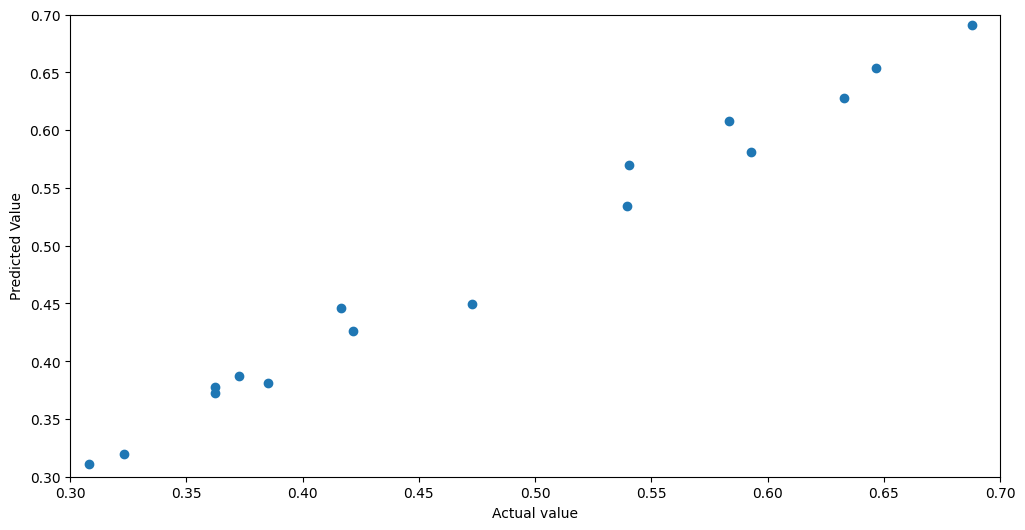

In [11]:
plt.scatter(true_value_train,predict_value_train)
plt.xlim(0.3,0.7)
plt.ylim(0.3,0.7)
plt.xlabel("Actual value")
plt.ylabel("Predicted Value")
plt.show

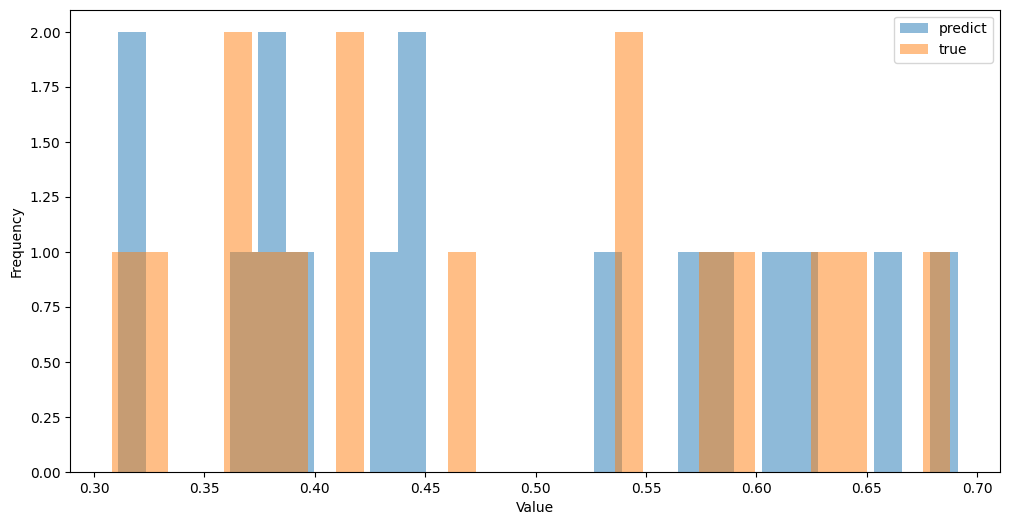

In [12]:
plt.hist(predict_value_train, bins=30, alpha=0.5, label='predict')
plt.hist(true_value_train, bins=30, alpha=0.5, label='true')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

train_MSE: 0.00012253828020818253
train_RMSE: 0.015315466845132393
train_MAE: 0.008804786382359236
train_MAPE: 0.015968647642356542
train_R2: 0.9904102146064688


<function matplotlib.pyplot.show(close=None, block=None)>

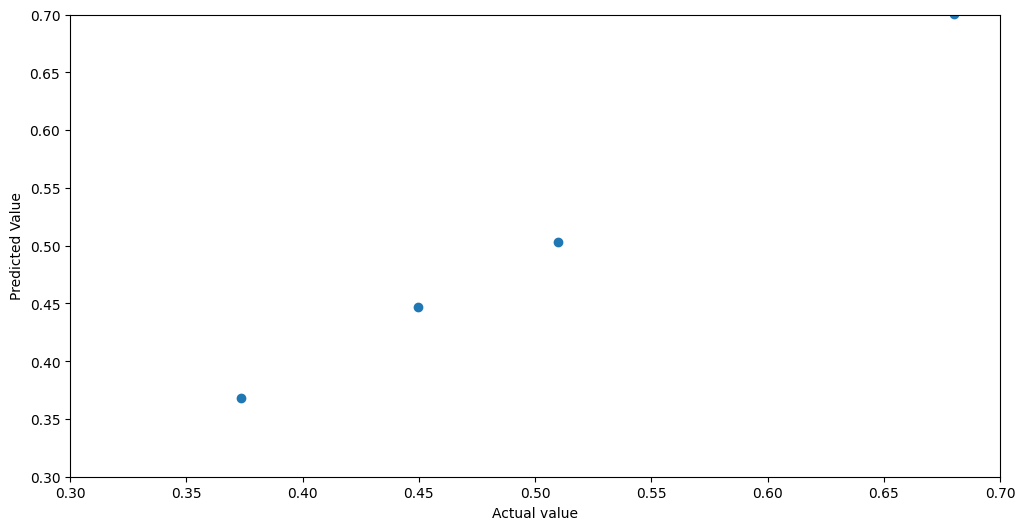

In [13]:
predict_value_test= model(Tensor(xtv_test_log)).detach().numpy()
true_value_test=np.array(ytv_test_log).reshape(predict_value_test.shape)
test_MSE=metrics.mean_squared_error(true_value_test,predict_value_test)


test_RMSE=train_MSE**(1/2)

test_MAE=metrics.mean_absolute_error(true_value_test,predict_value_test)
test_MAPE=metrics.mean_absolute_percentage_error(true_value_test,predict_value_test)
test_R2=metrics.r2_score(true_value_test, predict_value_test)

print("train_MSE:",test_MSE)
print("train_RMSE:",test_RMSE)
print("train_MAE:",test_MAE)
print("train_MAPE:",test_MAPE)
print("train_R2:",test_R2)

plt.rcParams["figure.figsize"] = (12, 6)

plt.scatter(true_value_test,predict_value_test)
plt.xlim(0.3,0.7)
plt.ylim(0.3,0.7)
plt.xlabel("Actual value")
plt.ylabel("Predicted Value")
plt.show


In [14]:
print(predict_value_test)

[[0.44723696]
 [0.5029356 ]
 [0.36778507]
 [0.70038205]]


In [15]:
print(true_value_test)

[[0.44981605]
 [0.50990257]
 [0.3733618 ]
 [0.68028572]]


train_MSE: 0.0005860234030148403
train_RMSE: 0.024207920253810328
train_MAE: 0.01970434622105193
train_MAPE: 0.04275956495915443
train_R2: 0.9564497156281712


<function matplotlib.pyplot.show(close=None, block=None)>

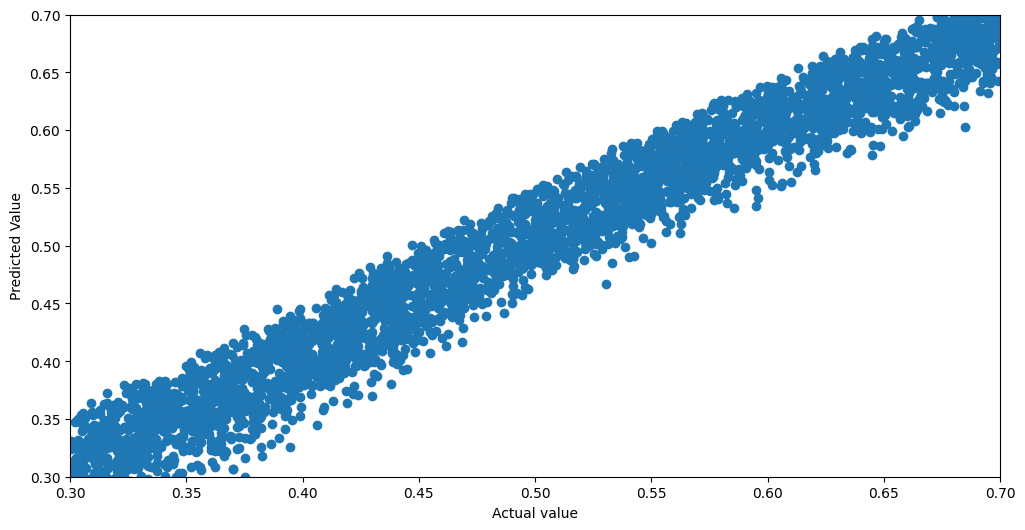

In [16]:
x_tests=np.loadtxt('x_s.txt')
y_tests=np.loadtxt('y_s.txt')


predict_value_tests= model(Tensor(x_tests)).detach().numpy()
true_value_tests=np.array(y_tests).reshape(predict_value_tests.shape)
tests_MSE=metrics.mean_squared_error(true_value_tests,predict_value_tests)


tests_RMSE=tests_MSE**(1/2)

tests_MAE=metrics.mean_absolute_error(true_value_tests,predict_value_tests)
tests_MAPE=metrics.mean_absolute_percentage_error(true_value_tests,predict_value_tests)
tests_R2=metrics.r2_score(true_value_tests, predict_value_tests)

print("train_MSE:",tests_MSE)
print("train_RMSE:",tests_RMSE)
print("train_MAE:",tests_MAE)
print("train_MAPE:",tests_MAPE)
print("train_R2:",tests_R2)

plt.rcParams["figure.figsize"] = (12, 6)

plt.scatter(true_value_tests,predict_value_tests)
plt.xlim(0.3,0.7)
plt.ylim(0.3,0.7)
plt.xlabel("Actual value")
plt.ylabel("Predicted Value")
plt.show